In [4]:
include("astrobee_se3_script.jl")
using Plots

N = 100
MAX_ITERATIONS_NB = 10

model = Astrobee()

Xp,Up = initialize_trajectory(model, N)
X, U  = copy(Xp) .+ 2., copy(Up) .+ 2.

SCPproblem = GuSTOProblem(model, N, Xp, Up)

x_dim, u_dim = model.x_dim, model.u_dim

Delta0, omega0, omegamax, 
    epsilon, rho0, rho1, 
    beta_succ, beta_fail, gamma_fail, 
    convergence_threshold = get_initial_gusto_parameters(model)

Delta = Delta0
omega = omega0

# X = zeros(x_dim, N)
# U = zeros(u_dim, N-1)
println("oh yeah")

oh yeah


In [5]:
include("astrobee_se3_script.jl")

X_all, U_all, x_shooting_all = [], [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

B_success = false
it = 0

while it<MAX_ITERATIONS_NB && 
        !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
            convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
        omega<omegamax
    println("-----------")
    println("Iteration $it")
    println("metric=$(convergence_metric(model,X,U,Xp,Up))")
    println("-----------")
    
    
#     omega, Delta = SCPproblem.omega, SCPproblem.Delta
    
    Xp = copy(X)
    Up = copy(U)
    
    model.f, model.A, model.B = compute_dynamics(model, Xp, Up)
    
    reset_problem(SCPproblem, model)
    set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    JuMP.optimize!(SCPproblem.solver_model)    
    p0 = get_initial_constraint_dual_variable(SCPproblem, model)
    println("dual variables:", p0)
    # get solution
    X_sol = JuMP.value.(SCPproblem.X)
    U_sol = JuMP.value.(SCPproblem.U)
    
    # try shooting
    #x_shooting, sol_newton = solve_shooting(SCPproblem, model, p0)
#     x_shooting = solve_shooting_once(SCPproblem, model, p0)
    #push!(x_shooting_all, x_shooting)
    
    # -----------
    # GuSTO Logic
    if it > 3
        if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
            rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

            if rho > rho1
                println("Reject solution.")
                Delta = beta_fail * Delta
                omega     = omega
                B_success = false

            else
                println("Accept solution.")
                X = copy(X_sol)
                U = copy(U_sol)
                B_success = true
                if rho < rho0
                    Delta = min(beta_succ*Delta, Delta0)
                else
                    Delta = Delta
                end
                if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                    omega = omega0
                else
                    println("Solution does not satisfy state constraints, increasing omega.")
                    omega = gamma_fail * omega
                end
            end
        else
            println("Reject solution (Outside trust region)")
            Delta = Delta
            omega     = gamma_fail * omega
            B_success = false
        end
#         if convergence_metric(model,X,U,Xp,Up) <0.6
#             println("Convergence metric very small. Decreasing Delta.")
#             Delta = Delta0./(2^it)
#         end
            
    else # always accept first solution
        X = copy(X_sol)
        U = copy(U_sol)
    end
        
                    
    # -----------

    push!(X_all, copy(X))
    push!(U_all, copy(U))
                    
    
    it += 1
    
    diff_with_prev = norm(copy(X) - copy(Xp), Inf)
    println("x(k) - x(k-1) = $diff_with_prev")
    println("Parameters:")
    println("omega=$omega")
    println("delta=$Delta")
end
println("Converged")

-----------
Iteration 0
metric=94.24868789068172
-----------
dual variables:[-270.668, -400.586, -342.617, -144.913, -198.977, -174.902, -7.14746, -5.8983, -6.13819, -5.50417, -4.2453, -5.7886, -5.34709]
x(k) - x(k-1) = 2.6909960674306435
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=140.84375085044599
-----------
dual variables:[-7.06657, -9.27281, -8.27588, -23.4821, -28.1013, -26.0392, -14.3316, 3.41143, 3.2969, 2.581, -0.974696, 0.78851, 3.95357]
x(k) - x(k-1) = 2.478456819905472
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 2
metric=81.8516064795417
-----------
dual variables:[-3.17022, -3.63039, -3.42691, -14.0764, -15.2703, -14.7569, -15.1225, 11.7302, 24.6223, 25.1702, -7.0054, 3.41485, 4.56105]
x(k) - x(k-1) = 3.755329220608247
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 3
metric=98.14982640124785
-----------
dual variables:[-2.14716, -2.35088, -2.26226, -10.8544, -11.3449, -11.1457, -14.0554, 2.44047, 12.0483, -17.6959, -3.58027, 0.

In [6]:
println("i is  $it")
println("metric=$(convergence_metric(model,X,U,Xp,Up))")
diff_with_prev = norm(copy(X) - copy(Xp), Inf)
println("x(k) - x(k-1) = $diff_with_prev")
    println("Parameters:")
    println("omega=$omega")
    println("delta=$Delta")
p0 = get_initial_constraint_dual_variable(SCPproblem, model)
println("dual variables:", p0)

i is  10
metric=6.096896806712271
x(k) - x(k-1) = 0.17406623162381596
Parameters:
omega=1.0
delta=1000.0
dual variables:[-0.832279, -0.840622, -0.838514, -5.7253, -5.56858, -5.65465, -0.0866928, 0.0416977, 0.20291, 13.5952, -0.0700856, 0.0810913, 0.229893]


In [7]:
gamma_fail

5.0

In [8]:
init_duals = get_initial_constraint_dual_variable(SCPproblem, model)

13-element Array{Float64,1}:
 -0.8322791068696677 
 -0.8406222023803211 
 -0.8385140733390261 
 -5.725303178142268  
 -5.568579295258677  
 -5.654652531179601  
 -0.0866928422976282 
  0.04169774992881767
  0.20291030356691214
 13.595225071315918  
 -0.07008559014476434
  0.08109127871215456
  0.22989266911659978

In [16]:
include("astrobee_se3_script.jl")
 
sol_newton = solve_shooting(SCPproblem, model, get_initial_constraint_dual_variable(SCPproblem, model))
x_shooting = solve_shooting_once(SCPproblem, model, sol_newton.zero)

sol_minpack.converged = false
sol_minpack.msg = "iteration is not making good progress, measured by improvement from last 10 iterations"
sol_minpack.return_code = 5


ErrorException: type Tuple has no field zero

In [17]:
xN = x_shooting[:,end]

for i = 1:x_dim
    Fi = model.x_final[i] - xN[i]
    @show Fi
end

UndefVarError: UndefVarError: x_shooting not defined

In [18]:

    for x_shooting in x_shooting_all
        if size(x_shooting,1) > 1
        @show minimum(x_shooting)
        end
end

In [19]:
x_shooting_all

0-element Array{Any,1}

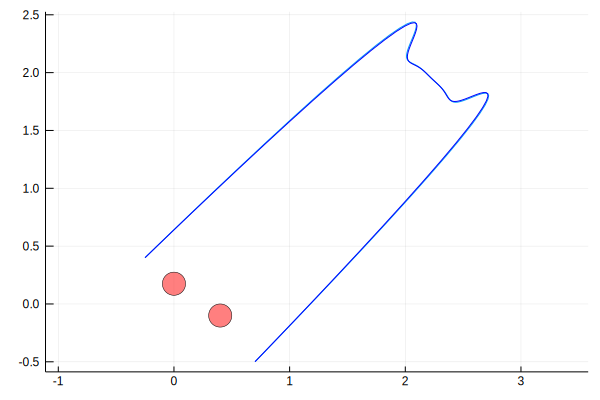

In [20]:
include("astrobee_se3_script.jl")
#plot(X[1,:],X[2,:])

plot_solutions(SCPproblem, model, X_all[end-1:end], U_all[end-1:end]; x_shooting_all=x_shooting_all)

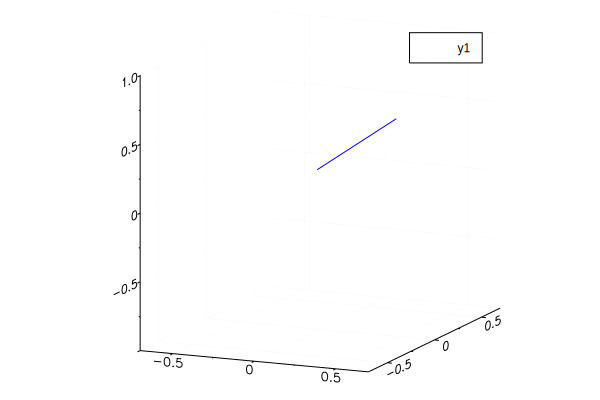

In [21]:
X = X_all[end]
# Xs = x_shooting_all[2]
 fig = plot(X[1,:], X[2,:], X[3,:]; c=:blue, lims = (-0.7,0.7))
# plot!(fig, Xs[1,:], Xs[2,:], Xs[3,:]; c=:red)

xlims = (0,10)
zlims = (0,10)
fig

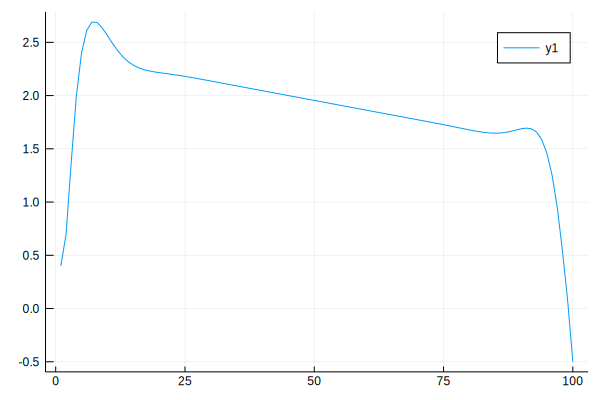

In [15]:
idx = [1,2]
x = X_all[2][1,:]
y = X_all[2][2,:]
z = X_all[2][3,:]
# plot(x,  y)
plot(1:N, y)